Kvasir dataset split into neg/pos and trained using Resnet50 without augmentation. Getting some decent results after training on resampled data with large step-size.  
- Class weighting  
- Resampling  
- Initial Bias-estimation
- Decreasing learning rate

### Loading data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/hyper-kvasir/labeled/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "model": 'self-trained',
    "ds_info": 'complete',
    "resample": False,
    "neg_class": ['normal-cecum'],
    "num_epochs": 30,
    "batch_size": 128,
    "img_shape": (32, 32, 3),
    "outcast": None,
    "optimizer": 'Adam',
    "final_activation": 'softmax',
    "learning_rate": 0.01,
    "early_stopping_patience": 10,
    "decay_rate": 0.4,              # higher number gives steeper dropoff
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

learning_rate = config["learning_rate"]
fine_tune_at = 130
fine_tune_epochs = 20
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]
class_names = params["class_names"]
neg = params["neg_count"]
pos = params["pos_count"]
total = params["ds_size"]

Directories:  ['hemorrhoids' 'barretts' 'esophagitis-a' 'esophagitis-b-d'
 'ulcerative-colitis-0-1' 'barretts-short-segment' 'cecum' 'pylorus'
 'retroflex-rectum' 'ulcerative-colitis-grade-2'
 'ulcerative-colitis-grade-1' 'bbps-2-3' 'bbps-0-1' 'ileum'
 'retroflex-stomach' 'normal-z-line' 'ulcerative-colitis-2-3'
 'impacted-stool' 'polyps' 'dyed-resection-margins' 'dyed-lifted-polyps'
 'ulcerative-colitis-grade-3' 'ulcerative-colitis-1-2']

hemorrhoids                 :    6 | 0.06%
barretts                    :   41 | 0.38%
esophagitis-a               :  403 | 3.78%
esophagitis-b-d             :  260 | 2.44%
ulcerative-colitis-0-1      :   35 | 0.33%
barretts-short-segment      :   53 | 0.50%
cecum                       : 1009 | 9.46%
pylorus                     :  999 | 9.37%
retroflex-rectum            :  391 | 3.67%
ulcerative-colitis-grade-2  :  443 | 4.15%
ulcerative-colitis-grade-1  :  201 | 1.89%
bbps-2-3                    : 1148 | 10.77%
bbps-0-1                    :  646 | 6.

# Step 1
Train a teacher model on labeled images

In [4]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, UpSampling2D, BatchNormalization

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import datetime

### Create and compile the model

In [5]:
resnet_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=config["img_shape"]
)

In [6]:
# Freeze layers in resnet
resnet_model.trainable = True

# Define model
resnet50_model = Sequential()

resnet50_model.add(resnet_model)
resnet50_model.add(GlobalAveragePooling2D())
resnet50_model.add(Dense(params["num_classes"], activation=config["final_activation"]))


if config['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif config['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

resnet50_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

### Callbacks

In [7]:
# By using LearnignRateScheduler
initial_learning_rate = learning_rate
decay_steps = params["train_size"] // config["batch_size"]
batch_size = config['batch_size']
decay_rate = config['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss',verbose=1, patience=early_stopping_patience, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb, lr_schedule_cb]

# Write config dictionary to text file
f = open(log_dir+"/config.txt","w")
f.write( str(config) )
f.close()

### Train the model

In [8]:
history = resnet50_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

# Write history dictionary to text file
f = open(log_dir+"/history.txt","w")
f.write( str(history.history) )
f.close()

Train for 58 steps, validate for 12 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/30
58/58 [==============================] - 133s 2s/step - loss: 4.7965 - sparse_categorical_accuracy: 0.1540 - val_loss: 4970110442.6667 - val_sparse_categorical_accuracy: 0.0918

Epoch 00002: LearningRateScheduler reducing learning rate to 0.005311355311355312.
Epoch 2/30
58/58 [==============================] - 3s 54ms/step - loss: 2.2905 - sparse_categorical_accuracy: 0.2776 - val_loss: 2.8302 - val_sparse_categorical_accuracy: 0.1048

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0036159600997506237.
Epoch 3/30
58/58 [==============================] - 3s 55ms/step - loss: 1.8019 - sparse_categorical_accuracy: 0.4192 - val_loss: 2.8640 - val_sparse_categorical_accuracy: 0.1035

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00274102079395085.
Epoch 4/30
58/58 [==============================] - 3s 54ms/step - loss: 1.4842 - sparse_cat

`Keras`
Save/load the model

## Evaluate the model

In [9]:
resnet50_evaluate = resnet50_model.evaluate(val_ds, verbose=2, steps=val_steps)

# Write evaluate dictionary to text file
f = open(log_dir+"/evaluate.txt","w")
f.write( str(resnet50_evaluate) )
f.close()

12/12 - 37s - loss: 0.4633 - sparse_categorical_accuracy: 0.8333


In [23]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(history.epoch[-1]+1)

In [ ]:
# Plot the learning rate
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, history.history['lr'], label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learnign rate')
plt.savefig(log_dir+'/learning_rate.png')
plt.title('Adaptive Learning Rate');

In [ ]:
# Plot train-val accuracy and loss
plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0.0, 3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.savefig(log_dir+'/accuracy_and_loss.png')
plt.show()

### Fine tune the model

In [ ]:
res_net.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(res_net.layers))

# Freeze all the layers before the `fine_tune_at` layer
for layer in res_net.layers[:fine_tune_at]:
    layer.trainable = False

print("Number of layers unfreezed: ", len(resnet50_model.trainable_variables))

In [ ]:
if config['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif config['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

resnet50_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [24]:
total_epochs = history.epoch[-1] + fine_tune_epochs

history_fine = resnet50_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = total_epochs,
    initial_epoch = history.epoch[-1],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 58 steps, validate for 12 steps

Epoch 00030: LearningRateScheduler reducing learning rate to 0.0003759398496240601.
Epoch 30/49
58/58 [==============================] - 14s 243ms/step - loss: 0.2857 - sparse_categorical_accuracy: 0.8966 - val_loss: 0.3465 - val_sparse_categorical_accuracy: 0.8848

Epoch 00031: LearningRateScheduler reducing learning rate to 0.0003638644918444166.
Epoch 31/49
58/58 [==============================] - 14s 235ms/step - loss: 0.2765 - sparse_categorical_accuracy: 0.9006 - val_loss: 0.3522 - val_sparse_categorical_accuracy: 0.8770

Epoch 00032: LearningRateScheduler reducing learning rate to 0.0003525407245319718.
Epoch 32/49
58/58 [==============================] - 14s 236ms/step - loss: 0.2670 - sparse_categorical_accuracy: 0.9023 - val_loss: 0.4059 - val_sparse_categorical_accuracy: 0.8620

Epoch 00033: LearningRateScheduler reducing learning rate to 0.00034190049516623437.
Epoch 33/49
58/58 [==============================] - 14s 236ms/step - l

In [60]:
# For fine-tuning
acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

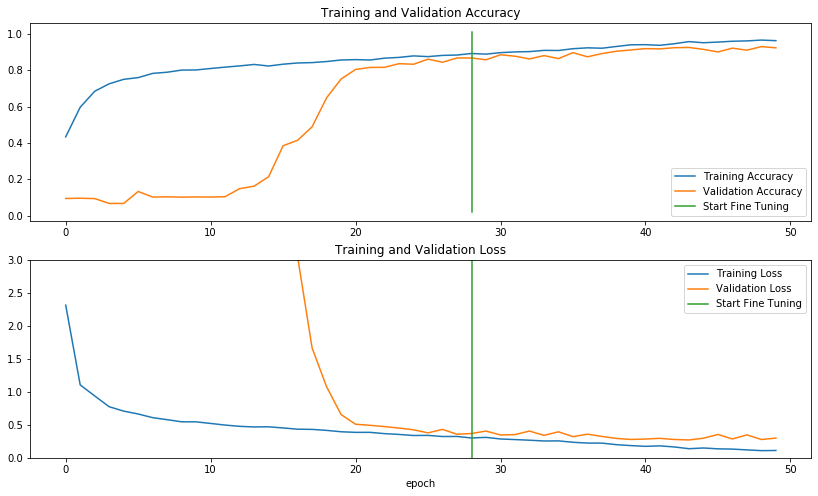

Fine tuning from epoch:  29


In [26]:
# Subplot 1
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([history.epoch[-1]-1,history.epoch[-1]-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([history.epoch[-1]-1,history.epoch[-1]-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

print ("Fine tuning from epoch: ", history.epoch[-1])

`Tensorboard`

In [ ]:
from tensorboard import notebook
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start tensorboard
%tensorboard --logdir logs

notebook.list()

# Step 2  
Use the teacher to generate pseudo labels on unlabeled images

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_dir_unlabeled = pathlib.Path('/mnt/sdb/hyper-kvasir/unlabeled_test/')

ds_size_unlabeled = len(list(data_dir_unlabeled.glob('*.*g')))

files_string = str(data_dir_unlabeled/'*.*g')
list_ds_unlabeled = tf.data.Dataset.list_files(files_string)
if config["verbosity"] > 0: 
    print ("Dataset.list_files: ", files_string, "\n")
    print ('Number of unlabeled images: {}'.format(ds_size_unlabeled))

def get_label(file_path):
    # Return 0 for all samples
    return tf.constant(0, tf.int32)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [config["img_shape"][0], config["img_shape"][1] ])

def process_path(file_path):
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img#, label

unlabeled_ds = list_ds_unlabeled.map(process_path, num_parallel_calls=AUTOTUNE)

Dataset.list_files:  /mnt/sdb/hyper-kvasir/unlabeled_test/*.*g 

Number of unlabeled images: 29


In [12]:
unlabeled_ds = unlabeled_ds.batch(1).prefetch(buffer_size=AUTOTUNE)

In [13]:
unlabeled_pred = resnet50_model.predict(unlabeled_ds)

In [23]:
count = 0
for path in list_ds_unlabeled.take(1):
    print (path)

predictions = unlabeled_pred[count]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred, class_names[i]))

print ("Predicton:", class_names[np.argmax(predictions)])

# plt.figure(frameon=False, facecolor='white')
# plt.imshow(image)
# plt.axis('off');

tf.Tensor(b'/mnt/sdb/hyper-kvasir/unlabeled_test/0a0b455d-d3dd-4be4-a6a3-90f81d8c8f36.jpg', shape=(), dtype=string)
0.0000 hemorrhoids
0.0000 barretts
0.0000 esophagitis-a
0.0000 esophagitis-b-d
0.0003 ulcerative-colitis-0-1
0.0000 barretts-short-segment
0.0001 cecum
0.0001 pylorus
0.0098 retroflex-rectum
0.0006 ulcerative-colitis-grade-2
0.0001 ulcerative-colitis-grade-1
0.0005 bbps-2-3
0.0627 bbps-0-1
0.0000 ileum
0.4824 retroflex-stomach
0.0000 normal-z-line
0.0007 ulcerative-colitis-2-3
0.0066 impacted-stool
0.0012 polyps
0.1212 dyed-resection-margins
0.3123 dyed-lifted-polyps
0.0002 ulcerative-colitis-grade-3
0.0012 ulcerative-colitis-1-2
Predicton: retroflex-stomach


## Predict new samples

In [27]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0000 hemorrhoids
0.0000 barretts
0.0000 esophagitis-a
0.0000 esophagitis-b-d
0.0000 ulcerative-colitis-0-1
0.0000 barretts-short-segment
0.0000 cecum
0.0000 pylorus
0.0000 retroflex-rectum
0.0000 ulcerative-colitis-grade-2
0.0000 ulcerative-colitis-grade-1
0.0056 bbps-2-3
0.0025 bbps-0-1
0.0003 ileum
0.0000 retroflex-stomach
0.0000 normal-z-line
0.0000 ulcerative-colitis-2-3
0.9916 impacted-stool
0.0000 polyps
0.0000 dyed-resection-margins
0.0000 dyed-lifted-polyps
0.0000 ulcerative-colitis-grade-3
0.0000 ulcerative-colitis-1-2

Label: impacted-stool
Predicton: impacted-stool


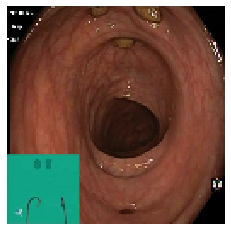

In [56]:
# Get a random image and label
rand = np.random.randint(0, config["batch_size"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resnet50_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred, class_names[i]))

print ("\nLabel:", class_names[label])
print ("Predicton:", class_names[np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [29]:
# Predict one batch
predictions = resnet50_model.predict(images)

print ('{:3}  {:<27} {:27}'.format('idx', 'label', 'pred'))
print ('---  {} {}'.format(27*'-', 27*'-'), end='')

# make a list to store the wrong predictions
wrong_predictions = []

for i, pred in enumerate(predictions):
    label = class_names[labels[i]]
    prediction = class_names[np.argmax(pred)]
    print ('\n{:3}  {:27} {:27}'.format(i, label, prediction), end='')
    if (label != prediction): 
        print ("-Incorrect-", end='')
        wrong_predictions.append(i)

idx  label                       pred                       
---  --------------------------- ---------------------------
  0  polyps                      polyps                     
  1  dyed-lifted-polyps          dyed-lifted-polyps         
  2  dyed-lifted-polyps          dyed-resection-margins     -Incorrect-
  3  bbps-0-1                    bbps-0-1                   
  4  normal-z-line               normal-z-line              
  5  normal-z-line               normal-z-line              
  6  normal-z-line               normal-z-line              
  7  dyed-resection-margins      dyed-resection-margins     
  8  bbps-0-1                    bbps-0-1                   
  9  normal-z-line               normal-z-line              
 10  bbps-2-3                    bbps-2-3                   
 11  cecum                       cecum                      
 12  polyps                      polyps                     
 13  pylorus                     pylorus                    
 14  bbps-2-3

In [30]:
# Print info about wrong predictions
print("List of wrong predictions from batch:" ,wrong_predictions)
color_string = "\x1b[31m{:0.4f} {}\x1b[0m"

for i, wrong_pred in enumerate(wrong_predictions):
    
    image = images[wrong_pred]
    label = labels[wrong_pred]
    
    # Predict one image
    predictions = resnet50_model.predict(np.expand_dims(image, axis=0))[0]
    pred_label = np.argmax(predictions)
    
    print ("\n\nLabel:", class_names[label])
    print ("Predicton:", class_names[pred_label])
    print ("-------------------------------------")
    for i, pred in enumerate(predictions):
        # print in colors
        if i == pred_label:
            print(color_string.format(pred, class_names[i]))
        else:
            print("{:0.4f} {}".format(pred, class_names[i]))

#     plt.figure(frameon=False, facecolor='white')
#     plt.imshow(image)
#     plt.axis('off');

List of wrong predictions from batch: [2, 29, 58, 68, 79, 104, 120, 122]


Label: dyed-lifted-polyps
Predicton: dyed-resection-margins
-------------------------------------
0.0000 hemorrhoids
0.0000 barretts
0.0000 esophagitis-a
0.0000 esophagitis-b-d
0.0000 ulcerative-colitis-0-1
0.0000 barretts-short-segment
0.0000 cecum
0.0000 pylorus
0.0000 retroflex-rectum
0.0000 ulcerative-colitis-grade-2
0.0000 ulcerative-colitis-grade-1
0.0000 bbps-2-3
0.0005 bbps-0-1
0.0000 ileum
0.0000 retroflex-stomach
0.0000 normal-z-line
0.0000 ulcerative-colitis-2-3
0.0000 impacted-stool
0.0000 polyps
0.9351 dyed-resection-margins
0.0644 dyed-lifted-polyps
0.0000 ulcerative-colitis-grade-3
0.0000 ulcerative-colitis-1-2


Label: bbps-0-1
Predicton: bbps-2-3
-------------------------------------
0.0000 hemorrhoids
0.0000 barretts
0.0000 esophagitis-a
0.0000 esophagitis-b-d
0.0000 ulcerative-colitis-0-1
0.0000 barretts-short-segment
0.0000 cecum
0.0000 pylorus
0.0000 retroflex-rectum
0.0001 ulcerative-coliti